# Data driven prediction of battery cycle life before capacity degradation

Paper:

[Severson, K.A., Attia, P.M., Jin, N. et al. Data-driven prediction of battery cycle life before capacity degradation. Nat Energy 4, 383–391 (2019)](https://www.nature.com/articles/s41560-019-0356-8)


Data:

[Experimental Data Platform (matr.io))](https://data.matr.io/1/projects/5c48dd2bc625d700019f3204)


## Structure of this Notebook
- Read datasets from files into lists
- Reproduce figures
- Reproduce the three ML models

## Import packages and modules

In [8]:
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os, random
import numpy as np
import statistics

## Create a list containing the summary data (per cycle) for each cell

In [94]:
summary = []
directory = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\summary"
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    summary.append(pd.read_csv(f))

In [80]:
len(summary)

137

## Create a list containing
- the $\Delta Q_{100-10}(V)$ values
- cycle 10 data
- cycle 100 data 

## for every cell

In [81]:
DeltaQ100_10 = []
c10_discharge = []
c100_discharge = []
directory1 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\cycles_interpolated\DeltaQ100_10_discharge"
directory2 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\cycles_interpolated\cycle10_discharge"
directory3 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\cycles_interpolated\cycle100_discharge"
for filename in os.listdir(directory1):
    f1 = os.path.join(directory1,filename)
    DeltaQ100_10.append(pd.read_csv(f1))
    
for filename in os.listdir(directory2):
    f2 = os.path.join(directory2,filename)
    c10_discharge.append(pd.read_csv(f2))
    
for filename in os.listdir(directory3):
    f3 = os.path.join(directory3,filename)
    c100_discharge.append(pd.read_csv(f3))

print(len(DeltaQ100_10))
print(len(c10_discharge))
print(len(c100_discharge))

137
137
137


#### Overview of data in summary

In [11]:
summary[10].head(3)

,cycle_index,discharge_capacity,charge_capacity,discharge_energy,charge_energy,dc_internal_resistance,temperature_maximum,temperature_average,temperature_minimum,date_time_iso,energy_efficiency,charge_throughput,energy_throughput,charge_duration,time_temperature_integrated,paused
0,0,1.559709,1.067177,4.779114,3.722037,0.016217,37.493538,31.868103,22.183815,2018-04-13T01:27:28+00:00,1.284005,1.067178,3.722037,101632.0,NaN,0
1,1,1.069160,1.068725,3.257659,3.709189,0.016010,37.531200,34.545357,31.361633,2018-04-14T06:19:44+00:00,0.878267,2.135903,7.431225,640.0,1611.899363,0
2,2,1.070147,1.069783,3.261968,3.711117,0.015988,37.512012,34.551731,31.414553,2018-04-14T07:06:40+00:00,0.878972,3.205686,11.142343,640.0,1611.789050,0


#### Overview of data in cycle 10

In [77]:
c10_discharge[10].head(3)

,cycle_index,discharge_capacity,charge_capacity,voltage,internal_resistance,temperature,current,step_type,cycle_life
0,9,0.996691,1.07224,2.800000,0.015931,35.622414,-4.400020,discharge,1046
1,9,0.996478,1.07224,2.800701,0.015931,35.620228,-4.400031,discharge,1046
2,9,0.996264,1.07224,2.801401,0.015931,35.618042,-4.400043,discharge,1046


#### Overview of $\Delta Q_{100-10}(V)$ data

In [78]:
DeltaQ100_10[10].head(3)

,discharge_capacity,cycle_life
0,-0.015909,1046
1,-0.015916,1046
2,-0.015923,1046


# Figures From Paper

#### First make colormap sorting all cells according to cycle life
- Creates an array of RGB colors from blue to red, where red is short cycle life and blue is long

In [82]:
from matplotlib.colors import LinearSegmentedColormap

cl_all = []
for cell in summary:
    cl_all.append(cell.index[-1])
    
cl_all = np.array(cl_all)
cl_all = np.sort(cl_all)[::-1]
cl_all_norm = minmax_scale(cl_all)

colormap = mpl.cm.ScalarMappable(cmap='RdBu_r')
colors_all = colormap.to_rgba(cl_all_norm)

In [83]:
len(colors_all)

137

#### Fig 1a

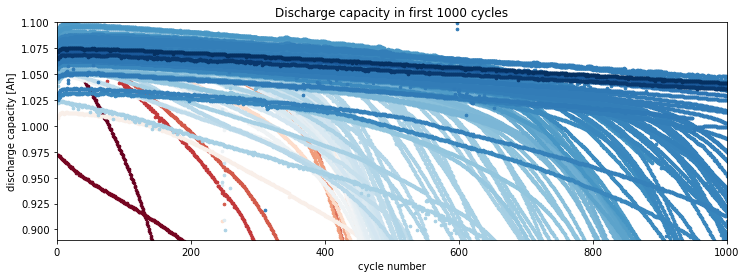

In [84]:
# Sort cells according to cycle life
summary = sorted(summary, key=lambda x:x.index[-1])
Qd_ratios = []

# Plot
fig, ax = plt.subplots(figsize=(12,4))
i = 0
for cell in summary:
    Qd = cell['discharge_capacity'][1:-1]
    cycles = cell.index[1:-1]
    ax.scatter(cycles, Qd, s=7, color=colors_all[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,1000)
    ax.set_ylim(0.89,1.1)
    ax.set_title("Discharge capacity in first 1000 cycles")

    Qd_ratios.append(float(cell['discharge_capacity'][99]/cell['discharge_capacity'][1]))

    i += 1

#### Fig 1b

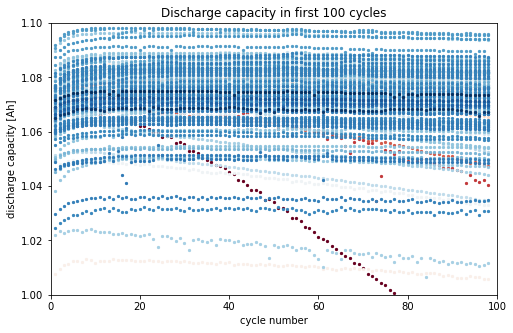

In [88]:
fig, ax = plt.subplots(figsize=(8,5))
i = 0
for cell in summary:
    Qd100 = cell['discharge_capacity'][1:99]
    cycles = cell.index[1:99]
    ax.scatter(cycles, Qd100, s=5, color=colors_all[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,100)
    ax.set_ylim(1,1.1)
    ax.set_title("Discharge capacity in first 100 cycles")
    
    i += 1

#### Fig 1c

Text(0.5, 1.0, 'Ratio of discharge capacity between cycle 100 and 2')

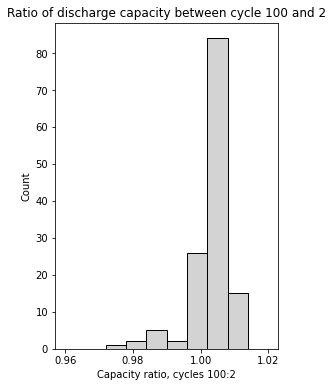

In [89]:
fig, ax = plt.subplots(figsize=(4,6))
ax.hist(Qd_ratios, range=(0.96,1.02), color='lightgrey', edgecolor='black')
ax.set_xticks([0.96, 0.98, 1.00, 1.02])
ax.set_xlabel('Capacity ratio, cycles 100:2')
ax.set_ylabel('Count', rotation=('vertical'))
ax.set_title('Ratio of discharge capacity between cycle 100 and 2')

#### Fig 1d-f

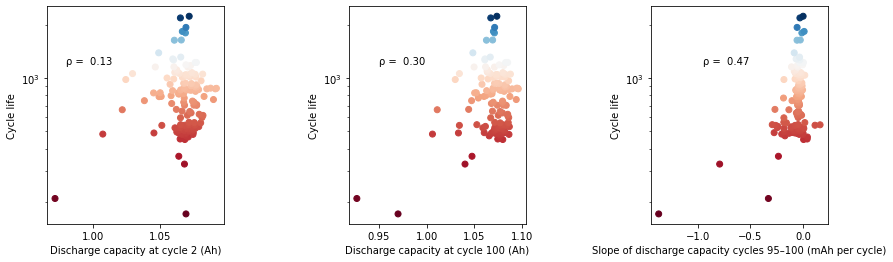

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

Qd_cycle2 = []
Qd_cycle100 = []
Qd_cycle_95_100 = []
cl = []

for cell in summary:
    cl.append(cell.index[-1])
    Qd_cycle2.append(float(cell['discharge_capacity'][1]))
    Qd_cycle100.append(float(cell['discharge_capacity'][99]))
    Qd_cycle_95_100.append(float(1000*(cell['discharge_capacity'][99] - cell['discharge_capacity'][94])/5))

    
# Correlation coefficients
corrcoef2 = np.corrcoef(np.log10(cl), Qd_cycle2)
corrcoef100 = np.corrcoef(np.log10(cl), Qd_cycle100)
corrcoef_95_100 = np.corrcoef(np.log10(cl), Qd_cycle_95_100)


# Scatter plots
ax[0].scatter(Qd_cycle2, cl, c=cl, cmap='RdBu')
ax[0].set_xlabel('Discharge capacity at cycle 2 (Ah)')
ax[0].set_ylabel('Cycle life', rotation='vertical')
ax[0].set_yscale('log')
ax[0].text(0.98, 1200, f"\u03C1 =  {corrcoef2[1,0]:.2f}")

ax[1].scatter(Qd_cycle100, cl, c=cl, cmap='RdBu')
ax[1].set_xlabel('Discharge capacity at cycle 100 (Ah)')
ax[1].set_ylabel('Cycle life', rotation='vertical')
ax[1].set_yscale('log')
ax[1].text(0.95, 1200, f"\u03C1 =  {corrcoef100[1,0]:.2f}")

ax[2].scatter(Qd_cycle_95_100, cl, c=cl, cmap='RdBu')
ax[2].set_xlabel('Slope of discharge capacity cycles 95–100 (mAh per cycle)')
ax[2].set_ylabel('Cycle life', rotation='vertical')
ax[2].set_yscale('log')
ax[2].text(-0.95, 1200, f"\u03C1 =  {corrcoef_95_100[1,0]:.2f}")

plt.subplots_adjust(wspace=0.7)

#### Fig 2a-c
- Note 1: Cells are cycled from 2.0 V to 3.6 V, but the data only shows the range 2.8 V to 3.6 V.
- Note 2: Cells have 1.1 Ah nominall capacity, but the data only shows charging from 0 to 1. Normalised?

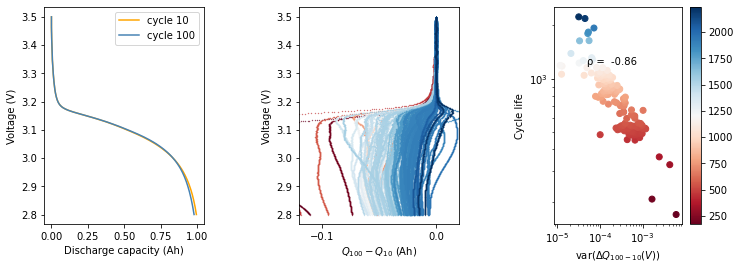

In [64]:
DQ_sorted = sorted(DeltaQ100_10, key=lambda x:x['cycle_life'].iloc[-1]) # Sort cells according to cycle life

voltage = np.linspace(2.8,3.5,1000) # Same voltage points for all cycles
var_DQ = [] # Var(Q_100-10)
cycle_lives = []

fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# Fig 2a: Qd for cycle 10 and 100
Qd10 = c10_discharge[10]['discharge_capacity'].values
Qd100 = c100_discharge[10]['discharge_capacity'].values
ax[0].plot(Qd10, voltage, color='orange', label='cycle 10')
ax[0].plot(Qd100, voltage, color='steelblue', label='cycle 100')
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)', rotation='vertical')
ax[0].legend()

for i in range(len(DQ_sorted)):
    cycle_lives.append(DQ_sorted[i]['cycle_life'].iloc[-1])
    
    # Fig 2b: Difference in Qd between cycle 100 and 10
    ax[1].scatter(DQ_sorted[i]['discharge_capacity'], voltage, s=0.1, color=colors_all[i])
    ax[1].set_xlim(-0.12,0.02)
    ax[1].set_xticks([-0.1, 0])
    ax[1].set_xlabel('$Q_{100} - Q_{10}$ (Ah)')
    ax[1].set_ylabel('Voltage (V)', rotation='vertical')
    
    var_DQ.append(float(np.var(DQ_sorted[i]['discharge_capacity'])))

corr_variance = np.corrcoef(np.log10(cycle_lives), np.log10(var_DQ))


# Fig 2c: var(Qd100-10) as function of cycle life
im = ax[2].scatter(var_DQ, cycle_lives, c=cycle_lives, cmap='RdBu')
fig.colorbar(im, ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('var($\u0394Q_{100-10}(V)$)')
ax[2].set_ylabel('Cycle life')
ax[2].text(0.00005, 1200, f"\u03C1 =  {corr_variance[1,0]:.2f}")

plt.subplots_adjust(wspace=0.6)

# ML models

There are three models in the paper, with increasing amount of available features. The features can be split into three categories.

Features based on $\Delta Q_{100-10}(V)$
- f1: min$(\Delta Q_{100-10}(V))$
- f2: mean$(\Delta Q_{100-10}(V))$
- f3: var$(\Delta Q_{100-10}(V))$
- f4: skewness$(\Delta Q_{100-10}(V))$
- f5: kurtosis$(\Delta Q_{100-10}(V))$

Features based on the discharge capacity fade curves
- f6: Slope of the linear fit to the capacity fade curve, cycles 2 to 100
- f7: Intercept of the linear fit to capacity fade curve, cycles 2 to 100
- f8: Slope of the linear fit to the capacity fade curve, cycles 91 to 100
- f9: Intercept of the linear fit to capacity fade curve, cycles 91 to 100
- f10: Discharge capacity, cycle 2
- f11: Difference between max discharge capacity and cycle 2
- f12: Discharge capacity, cycle 100

Other features
- f13: Average charge time, first 5 cycles
- f14: Maximum temperature, cycles 2 to 100
- f15: Minimum temperature, cycles 2 to 100
- f16: Integral of temperature over time, cycles 2 to 100
- f17: Internal resistance, cycle 2
- f18: Minimum internal resistance, cycles 2 to 100
- f19: Internal resistance, difference between cycle 100 and cycle 2

One additional feature from the paper, the discharge capacity at 2 V, is not included here. The reason is that the voltage in this dataset only ranges from 3.6 to 2.8 V as mentioned earlier in the Notebook.

In [68]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import skew, kurtosis

#### Error functions

In [69]:
def get_errors(y_train, y_test, y_train_pred, y_test_pred):
    mse_cycles_train = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    mse_cycles_test = mean_squared_error(np.power(10, y_test), np.power(10, y_test_pred), squared=False)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    
    return mse_cycles_train, mse_cycles_test, mape_train, mape_test

In [95]:
n_features = 19
n_targets = len(DeltaQ100_10)

# Prediction target
y = np.zeros(n_targets)

# Design matrix
X = np.zeros((n_targets,n_features))

# Intercycle features f1-f5
for i in range(len(DeltaQ100_10)):
    #Qd = cycles_interpolated[i].loc[cycles_interpolated[i]['step_type'] == 'discharge' , 'discharge_capacity']
    #Qd100_10 = Qd[99].values - Qd[9].values
    
    X[i,0] = np.log10(abs(np.amin(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,1] = np.log10(abs(np.mean(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,2] = np.log10(float(np.var(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,3] = np.log10(abs(skew(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,4] = np.log10(abs(kurtosis(DeltaQ100_10[i]['discharge_capacity'].values)))

# Per cycl[i]e features
for i in range(len(summary)):
    y[i] = np.log10(summary[i].index[-1])
    
    slope100_2 = float((summary[i]['discharge_capacity'][99] - summary[i]['discharge_capacity'][1])/98) #dQd / dcycle
    slope100_91 = float((summary[i]['discharge_capacity'][99] - summary[i]['discharge_capacity'][1])/9)
    intercept100_2 = summary[i]['discharge_capacity'][9] - slope100_2*10 # b = y-mx
    intercept100_91 = summary[i]['discharge_capacity'][9] - slope100_91*10 # b = y-mx
    diff = np.amax(summary[i]['discharge_capacity'][1:-1] - summary[i]['discharge_capacity'][1])
    
    
    X[i,5] = slope100_2
    X[i,6] = intercept100_2
    X[i,7] = slope100_91
    X[i,8] = intercept100_91
    X[i,9] = summary[i]['discharge_capacity'][1]
    X[i,10] = diff
    X[i,11] = summary[i]['discharge_capacity'][99]
    
    X[i,12] = np.mean(summary[i]['charge_duration'][1:6])
    X[i,13] = np.amax(summary[i]['temperature_maximum'][1:99])
    X[i,14] = np.amin(summary[i]['temperature_minimum'][1:99])
    X[i,15] = np.mean(summary[i]['time_temperature_integrated'][1:99])
    X[i,16] = summary[i]['dc_internal_resistance'][1]
    X[i,17] = np.amin(summary[i]['dc_internal_resistance'][1:99])
    X[i,18] = summary[i]['dc_internal_resistance'][99] - summary[i]['dc_internal_resistance'][1]

#### Feature generation

## First model: 'Variance' model

In [125]:
X_var = X[:,2].reshape(-1,1)

scaler = StandardScaler()
X_var_scaled = scaler.fit_transform(X_var)

X_train, X_test, y_train_var, y_test_var = train_test_split(X_var_scaled, y, test_size=0.2, random_state=22)

var_model = ElasticNetCV(cv=10)
var_model.fit(X_train, y_train_var)
var_pred_train = var_model.predict(X_train)
var_pred_test = var_model.predict(X_test)

print('RMSE Cycles train: %.4f, RMSE Cycles test: %.4f, MAPE train: %.4f, MAPE test: %.4f'\
      %(get_errors(y_train_var,y_test_var,var_pred_train,var_pred_test)))

# Comment about results: 
# Without using random_state, the results can vary by 100 cycles or more.
# This is most likely because of the small sample size of 30 cells.

RMSE Cycles train: 216.2551, RMSE Cycles test: 273.4896, MAPE train: 0.0220, MAPE test: 0.0308


## Second model: 'Discharge' model
Features f1-f13 are used as input to this model

In [127]:
X_discharge = X[:,0:12] #Shape (30,12)
X_discharge_scaled = scaler.fit_transform(X_discharge)


X_train, X_test, y_train_discharge, y_test_discharge = train_test_split(X_discharge_scaled, y, test_size=0.2, random_state=22)



discharge_model = ElasticNetCV(cv=10, max_iter=10000, tol=0.0001)
discharge_model.fit(X_train, y_train_discharge)
discharge_pred_train = discharge_model.predict(X_train)
discharge_pred_test = discharge_model.predict(X_test)

print('RMSE Cycles train: %.4f, RMSE Cycles test: %.4f, MAPE train: %.4f, MAPE test: %.4f'\
      %(get_errors(y_train_discharge,y_test_discharge,discharge_pred_train,discharge_pred_test)))

RMSE Cycles train: 183.8550, RMSE Cycles test: 221.1410, MAPE train: 0.0185, MAPE test: 0.0281


## Third model: 'Full' model

Features f1-f19 are used as input to this model

In [128]:
X_full = X # Shape (30,19)
X_full_scaled = scaler.fit_transform(X_full)

X_train, X_test, y_train_full, y_test_full = train_test_split(X_full_scaled, y, test_size=0.2, random_state=22)

full_model = ElasticNetCV(cv=10, max_iter=10000, tol=0.0001)
full_model.fit(X_train, y_train_full)
full_pred_train = full_model.predict(X_train)
full_pred_test = full_model.predict(X_test)

print('RMSE Cycles train: %.4f, RMSE Cycles test: %.4f, MAPE train: %.4f, MAPE test: %.4f'\
      %(get_errors(y_train_full,y_test_full,full_pred_train,full_pred_test)))

RMSE Cycles train: 162.7414, RMSE Cycles test: 146.7111, MAPE train: 0.0145, MAPE test: 0.0209


### Plots showing linear relationship between some features and cycle life

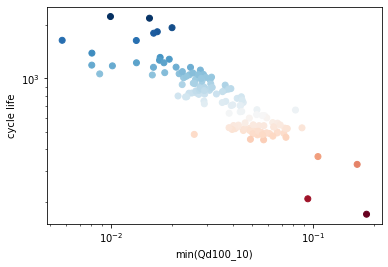

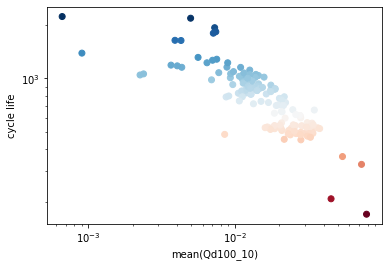

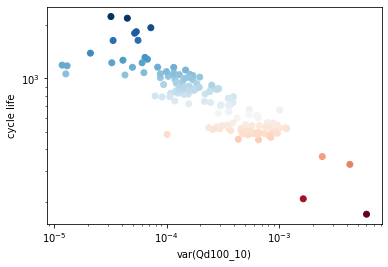

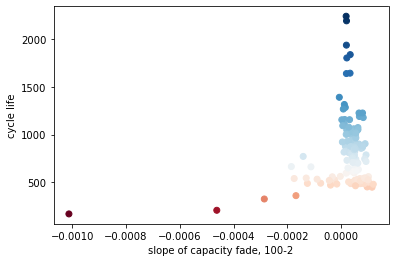

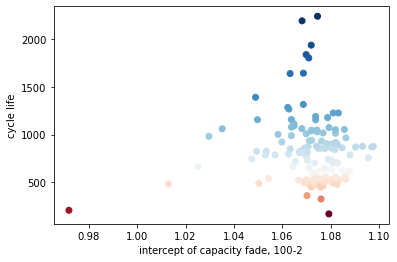

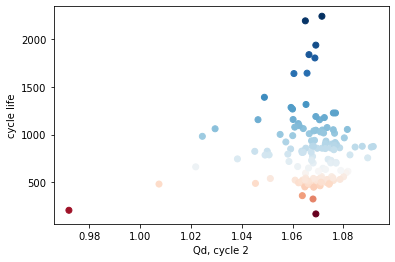

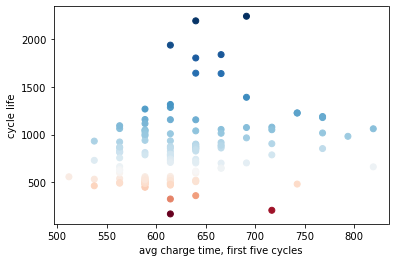

In [99]:
plt.scatter(np.power(10,X[:,0]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('min(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(np.power(10,X[:,1]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(np.power(10,X[:,2]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('var(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,5], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('slope of capacity fade, 100-2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,6], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('intercept of capacity fade, 100-2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,9], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('Qd, cycle 2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,12], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('avg charge time, first five cycles')
plt.ylabel('cycle life')
plt.show()

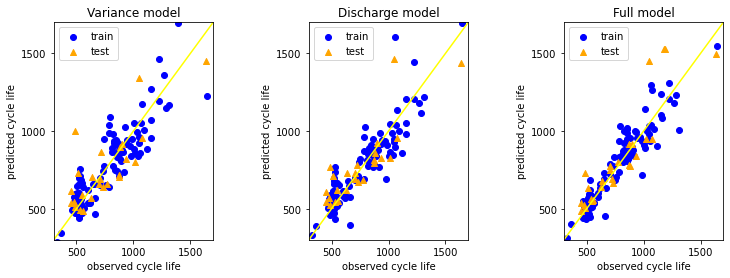

In [129]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

x_line = np.linspace(0,1700)
y_line = np.linspace(0,1700)

ax[0].scatter(np.power(10,y_train_var), np.power(10,var_pred_train), color='blue', label='train')
ax[0].scatter(np.power(10,y_test_var), np.power(10,var_pred_test), color='orange', marker='^', label='test')
ax[0].plot(x_line,y_line, color='yellow')
ax[0].set_xlim(300,1700)
ax[0].set_ylim(300,1700)
ax[0].set_xticks([500,1000,1500])
ax[0].set_yticks([500,1000,1500])
ax[0].set_xlabel('observed cycle life')
ax[0].set_ylabel('predicted cycle life')
ax[0].legend()
ax[0].set_title('Variance model')


ax[1].scatter(np.power(10,y_train_discharge), np.power(10,discharge_pred_train), color='blue', label='train')
ax[1].scatter(np.power(10,y_test_discharge), np.power(10,discharge_pred_test), color='orange', marker='^', label='test')
ax[1].plot(x_line,y_line, color='yellow')
ax[1].set_xlim(300,1700)
ax[1].set_ylim(300,1700)
ax[1].set_xticks([500,1000,1500])
ax[1].set_yticks([500,1000,1500])
ax[1].set_xlabel('observed cycle life')
ax[1].set_ylabel('predicted cycle life')
ax[1].legend()
ax[1].set_title('Discharge model')


ax[2].scatter(np.power(10,y_train_full), np.power(10,full_pred_train), color='blue', label='train')
ax[2].scatter(np.power(10,y_test_full), np.power(10,full_pred_test), color='orange', marker='^', label='test')
ax[2].plot(x_line,y_line, color='yellow')
ax[2].set_xlim(300,1700)
ax[2].set_ylim(300,1700)
ax[2].set_xticks([500,1000,1500])
ax[2].set_yticks([500,1000,1500])
ax[2].set_xlabel('observed cycle life')
ax[2].set_ylabel('predicted cycle life')
ax[2].legend()
ax[2].set_title('Full model')

plt.subplots_adjust(wspace=0.6)
plt.show()

Models performed significantly better after scaling

### manual calculation of variance for control 

In [74]:
print(np.power(10,X[0,2])) # Variance for first cell from np.var()

# Variance for first cell manually calculated
Qd = cycles_interpolated[0].loc[cycles_interpolated[0]['step_type'] == 'discharge' , 'discharge_capacity']
Qd100_10 = Qd[99].values - Qd[9].values
avg = np.mean(Qd100_10)
variance = float(sum((Qd100_10 - avg)**2)/len(Qd100_10))

print(variance)

0.00028431282957641255
0.00028431282957641245
